In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 
# os.environ['PT_XLA_DEBUG_LEVEL'] = '2'
# os.environ['XLA_DYNAMO_DEBU'] = '1'
# os.environ['PT_XLA_DEBUG'] = '1'
# os.environ['XLA_SYNC_WAIT'] = '1'
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [2]:
import imageio.v3 as iio
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    img_array = np.array(iio.imread(path)).reshape((125, 125, 8))
    return img_array

def load_images_from_directory(directory):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][:50000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    return images

# Load images from both directories
X_one = load_images_from_directory('/home/shashank/dataset/dataset/one/')
X_two = load_images_from_directory('/home/shashank/dataset/dataset/two/')

# Combine datasets
X = X_one + X_two

X_train = X[:int(len(X)*0.8)]
X_train = np.array(X_train).astype('float32')
X_test = X[int(len(X)*0.8):len(X)]
X_test = np.array(X_test).astype('float32')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:48<00:00, 1025.79it/s]


In [3]:
X_train /= 255.0
X_test /= 255.0

In [4]:


torch.manual_seed(42)
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=8, embed_dim=768, multi_conv=False):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        if multi_conv:
            if patch_size[0] == 12:
                self.proj = nn.Sequential(
                    nn.Conv2d(in_chans, embed_dim // 4, kernel_size=7, stride=4, padding=3),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=3, padding=0),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=1, padding=1),
                )
            elif patch_size[0] == 16:
                self.proj = nn.Sequential(
                    nn.Conv2d(in_chans, embed_dim // 4, kernel_size=7, stride=4, padding=3),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=2, padding=1),
                )
        else:
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):

        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B1C -> B1H(C/H) -> BH1(C/H)
        k = self.wk(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)
        v = self.wv(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # BH1(C/H) @ BH(C/H)N -> BH1N
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)   # (BH1N @ BHN(C/H)) -> BH1(C/H) -> B1H(C/H) -> B1C
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=True):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x)))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class MultiScaleBlock(nn.Module):

    def __init__(self, dim, patches, depth, num_heads, mlp_ratio, qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()

        num_branches = len(dim)
        self.num_branches = num_branches
        # different branch could have different embedding size, the first one is the base
        self.blocks = nn.ModuleList()
        for d in range(num_branches):
            tmp = []
            for i in range(depth[d]):
                tmp.append(
                    Block(dim=dim[d], num_heads=num_heads[d], mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, 
                          attn_drop=attn_drop, drop_path=drop_path[i], norm_layer=norm_layer))
            if len(tmp) != 0:
                self.blocks.append(nn.Sequential(*tmp))

        if len(self.blocks) == 0:
            self.blocks = None

        self.projs = nn.ModuleList()
        for d in range(num_branches):
            if dim[d] == dim[(d+1) % num_branches] and False:
                tmp = [nn.Identity()]
            else:
                tmp = [norm_layer(dim[d]), act_layer(), nn.Linear(dim[d], dim[(d+1) % num_branches])]
            self.projs.append(nn.Sequential(*tmp))

        self.fusion = nn.ModuleList()
        for d in range(num_branches):
            d_ = (d+1) % num_branches
            nh = num_heads[d_]
            if depth[-1] == 0:  # backward capability:
                self.fusion.append(CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                       drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1], norm_layer=norm_layer,
                                                       has_mlp=False))
            else:
                tmp = []
                for _ in range(depth[-1]):
                    tmp.append(CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                   drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1], norm_layer=norm_layer,
                                                   has_mlp=False))
                self.fusion.append(nn.Sequential(*tmp))

        self.revert_projs = nn.ModuleList()
        for d in range(num_branches):
            if dim[(d+1) % num_branches] == dim[d] and False:
                tmp = [nn.Identity()]
            else:
                tmp = [norm_layer(dim[(d+1) % num_branches]), act_layer(), nn.Linear(dim[(d+1) % num_branches], dim[d])]
            self.revert_projs.append(nn.Sequential(*tmp))

    def forward(self, x):
        outs_b = [block(x_) for x_, block in zip(x, self.blocks)]
        # only take the cls token out
        proj_cls_token = [proj(x[:, 0:1]) for x, proj in zip(outs_b, self.projs)]
        # cross attention
        outs = []
        for i in range(self.num_branches):
            tmp = torch.cat((proj_cls_token[i], outs_b[(i + 1) % self.num_branches][:, 1:, ...]), dim=1)
            tmp = self.fusion[i](tmp)
            reverted_proj_cls_token = self.revert_projs[i](tmp[:, 0:1, ...])
            tmp = torch.cat((reverted_proj_cls_token, outs_b[i][:, 1:, ...]), dim=1)
            outs.append(tmp)
        return outs


def _compute_num_patches(img_size, patches):
    return [i // p * i // p for i, p in zip(img_size,patches)]


class Encoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=(224, 224), patch_size=(8, 16), in_chans=8, num_classes=1000, embed_dim=(192, 384), depth=([1, 3, 1], [1, 3, 1], [1, 3, 1]),
                 num_heads=(6, 12), mlp_ratio=(2., 2., 4.), qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, multi_conv=False, mask_ratio = [0.75,0]):
        super().__init__()

        self.num_classes = num_classes
        self.mask_ratio = mask_ratio
        if not isinstance(img_size, list):
            img_size = to_2tuple(img_size)
        self.img_size = img_size

        num_patches = _compute_num_patches(img_size, patch_size)
        self.num_branches = len(patch_size)

        self.patch_embed = nn.ModuleList()
        if hybrid_backbone is None:
            self.pos_embed = nn.ParameterList([nn.Parameter(torch.zeros(1, 1 + int(num_patches[i]*(1-self.mask_ratio[i])), embed_dim[i])) for i in range(self.num_branches)])
            for im_s, p, d in zip(img_size, patch_size, embed_dim):
                self.patch_embed.append(PatchEmbed(img_size=im_s, patch_size=p, in_chans=in_chans, embed_dim=d, multi_conv=multi_conv))
        else:
            self.pos_embed = nn.ParameterList()
            from .t2t import T2T, get_sinusoid_encoding
            tokens_type = 'transformer' if hybrid_backbone == 't2t' else 'performer'
            for idx, (im_s, p, d) in enumerate(zip(img_size, patch_size, embed_dim)):
                self.patch_embed.append(T2T(im_s, tokens_type=tokens_type, patch_size=p, embed_dim=d))
                self.pos_embed.append(nn.Parameter(data=get_sinusoid_encoding(n_position=1 + num_patches[idx], d_hid=embed_dim[idx]), requires_grad=False))

            del self.pos_embed
            self.pos_embed = nn.ParameterList([nn.Parameter(torch.zeros(1, 1 + num_patches[i], embed_dim[i])) for i in range(self.num_branches)])

        self.cls_token = nn.ParameterList([nn.Parameter(torch.zeros(1, 1, embed_dim[i])) for i in range(self.num_branches)])
        self.pos_drop = nn.Dropout(p=drop_rate)

        total_depth = sum([sum(x[-2:]) for x in depth])
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_depth)]  # stochastic depth decay rule
        dpr_ptr = 0
        self.blocks = nn.ModuleList()
        for idx, block_cfg in enumerate(depth):
            curr_depth = max(block_cfg[:-1]) + block_cfg[-1]
            dpr_ = dpr[dpr_ptr:dpr_ptr + curr_depth]
            # print(f'{idx}: ', curr_depth)
            # print(f'{idx}: ', dpr_)
            blk = MultiScaleBlock(embed_dim, num_patches, block_cfg, num_heads=num_heads, mlp_ratio=mlp_ratio,
                                  qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr_,
                                  norm_layer=norm_layer)
            dpr_ptr += curr_depth
            self.blocks.append(blk)

        self.norm = nn.ModuleList([norm_layer(embed_dim[i]) for i in range(self.num_branches)])
        self.head = nn.ModuleList([nn.Linear(embed_dim[i], num_classes) if num_classes > 0 else nn.Identity() for i in range(self.num_branches)])

        for i in range(self.num_branches):
            if self.pos_embed[i].requires_grad:
                trunc_normal_(self.pos_embed[i], std=.02)
            trunc_normal_(self.cls_token[i], std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        out = {'cls_token'}
        if self.pos_embed[0].requires_grad:
            out.add('pos_embed')
        return out

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
        
    def forward_features(self, x):
        B, C, H, W = x.shape
        xs = []
        encoder_inputs = []
        masks = []
        ids_to_restore = []
        for i in range(self.num_branches):
            #---------------If images are of different_sizes---------------------
            x_ = torch.nn.functional.interpolate(x, size=(self.img_size[i], self.img_size[i]), mode='bicubic') if H != self.img_size[i] else x
            #---------------------------------------------------------------------
            
            tmp = self.patch_embed[i](x_) #Patch Embed shape(N, no.of.patches, embed_dim)

            #------------masking scheme-------------------
            masked_output, mask, ids_restore = self.random_masking(tmp, mask_ratio = self.mask_ratio[i])
            encoder_inputs.append(masked_output)
            masks.append(mask)
            ids_to_restore.append(ids_restore)
            #----------------------------------------------

            cls_tokens = self.cls_token[i].expand(B, -1, -1)  # CLS token
            tmp = torch.cat((cls_tokens, masked_output), dim=1)
            tmp = tmp + self.pos_embed[i] #Position Embed
            
            masked_output = self.pos_drop(tmp)
            xs.append(tmp)

        for blk in self.blocks:
            xs = blk(xs)

        # NOTE: was before branch token section, move to here to assure all branch token are before layer norm
        xs = [self.norm[i](x) for i, x in enumerate(xs)]
        # out = [x[:, 0] for x in xs]

        return xs, masks, ids_to_restore

    def forward(self, x):
        # outputs, masks, ids_restore = self.forward_features(x)
        # ce_logits = [self.head[i](x) for i, x in enumerate(xs)]
        # ce_logits = torch.mean(torch.stack(ce_logits, dim=0), dim=0)
        return self.forward_features(x)

In [5]:
import math
from collections import OrderedDict
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.ops.misc import Conv2dNormActivation, MLP
from torchvision.transforms._presets import ImageClassification, InterpolationMode
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface
import torch_xla.debug.metrics as met
# import torch_xla.debug.mark as mmark


class CrissCrossMultiheadSelfAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadSelfAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.qkv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.qkv_linear.append(nn.Linear(k_factor, k_factor * 3))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, qkv in zip(in_channels, self.qkv_linear):
            q, k, v = qkv(channel).chunk(3, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out

class CrissCrossMultiheadCrossAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadCrossAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.q_linear = nn.ModuleList()
        self.kv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.q_linear.append(nn.Linear(k_factor, k_factor))
            self.kv_linear.append(nn.Linear(k_factor, k_factor * 2))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x, context):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        context_in_channels = context.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, cont_channel, q_lin, kv_lin in zip(in_channels, context_in_channels, self.q_linear, self.kv_linear):
            q = q_lin(channel)
            k, v = kv_lin(cont_channel).chunk(2, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out


class ConvStemConfig(NamedTuple):
    out_channels: int
    kernel_size: int
    stride: int
    norm_layer: Callable[..., nn.Module] = nn.BatchNorm2d
    activation_layer: Callable[..., nn.Module] = nn.ReLU


class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )

class DecoderBlock(nn.Module):
    """Transformer decoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        in_channels: int,
        k_factor: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = CrissCrossMultiheadSelfAttention(k_factor, num_heads, in_channels)
        self.ln_2 = norm_layer(hidden_dim)
        self.cross_attention = CrissCrossMultiheadCrossAttention(k_factor, num_heads, in_channels)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_3 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor, context: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = self.ln_1(input)
        x = self.self_attention(input)
        input = input + self.dropout(x)
        x = self.ln_2(input)
        x = self.cross_attention(x, context)
        input = input + self.dropout(x)

        y = self.ln_3(x)
        y = self.mlp(y)
        return x + y


class Decoder(nn.Module):
    """Transformer Model Decoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_channels: int,
        k_factor: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.dec_pos_embedding = nn.Parameter(torch.empty(1, seq_length + 1, hidden_dim).normal_(std=0.02))  # from BERT
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = DecoderBlock(
                num_heads,
                hidden_dim,
                num_channels,
                k_factor,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.mask_tokens = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

    def forward(self, x, context, ids_restore, cls_tok = None):
        torch._assert(x.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {x.shape}")
        
        cls_token = self.cls_token + self.dec_pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # print('issue1')
        mask_tokens = self.mask_token.repeat(context.shape[0], ids_restore.shape[1] + 1 - context.shape[1], 1)
        context_ = torch.cat([context[:, 1:, :], mask_tokens], dim=1)  # no cls token
        context_ = torch.gather(context_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, context.shape[2]))  # unshuffle
        context = torch.cat([context[:, :1, :], context_], dim=1)  # append cls token
        context = context + self.dec_pos_embedding
        
        for l in self.layers:
            x = l(x, context)
        # print('issue2')
        return self.ln(x)

class DepthwiseCrossViTMAE(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: list,
        in_channels: int,
        k_factor: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        mask_ratio: float = 0.5,
        **kwargs
    ):
        super().__init__()
        _log_api_usage_once(self)
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.k_factor = k_factor
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.norm_layer = norm_layer
        self.mask_ratio = mask_ratio

        self.conv_proj = nn.ModuleList([nn.Conv2d(
                                                    in_channels=in_channels, groups=in_channels, 
                                                    out_channels=in_channels*k_factor, kernel_size=patch, 
                                                    stride=patch
                                                ) for patch in patch_size])

        seq_length = [(image_size // self.patch_size[i]) ** 2 for i in range(len(patch_size))]

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

        self.encoder = Encoder(img_size=[image_size, image_size],
                              patch_size=[patch_size[0], patch_size[1]], embed_dim=[hidden_dim, hidden_dim], depth=[[4, 4, 2], [4, 4, 2], [4, 4, 2]],
                              num_heads=[4, 4], mlp_ratio=[4, 4, 1], qkv_bias=True,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6), mask_ratio = [0.75,0], **kwargs)
        
        self.decoder_1 = Decoder(
            seq_length[0],
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )

        self.decoder_2 = Decoder(
            seq_length[1],
            
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )
        
        self.linear_proj_1 = nn.Linear(in_features = hidden_dim, out_features = 200)
        self.linear_proj_2 = nn.Linear(in_features = hidden_dim, out_features = 625*8)
        
        self.seq_length = seq_length
        # self.upsample = ReduceAndUpsample()
        for conv in self.conv_proj:
            if isinstance(conv, nn.Conv2d):
                # Init the patchify stem
                fan_in = conv.in_channels * conv.kernel_size[0] * conv.kernel_size[1]
                nn.init.trunc_normal_(conv.weight, std=math.sqrt(1 / fan_in))
                if conv.bias is not None:
                    nn.init.zeros_(conv.bias)
            elif conv.conv_last is not None and isinstance(conv.conv_last, nn.Conv2d):
                # Init the last 1x1 conv of the conv stem
                nn.init.normal_(
                    conv.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / conv.conv_last.out_channels)
                )
                if conv.conv_last.bias is not None:
                    nn.init.zeros_(conv.conv_last.bias)


    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = [self.conv_proj[i](x) for i in range(2)]
        # (n, in_channels * k_factor, n_h, n_w) -> (n, in_channels * k_factor, (n_h * n_w))
        x = [z.reshape(n, self.in_channels * self.k_factor, (h//p[step]) * (w//p[step])) for step, z in enumerate(x)]

        # (n, in_channels * k_factor, (n_h * n_w)) -> (n, (n_h * n_w), in_channels * k_factor)
        # The self attention layer expects inputs in the format (N, L, D)
        # where L is the source sequence length, N is the batch size, D is the
        # embedding dimension
        x = [z.permute(0, 2, 1) for z in x]

        return x

    def forward_loss(self, target, pred):
        """
        imgs: [N, C, H, W]
        pred: [N, L, p*p*C]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        pred = pred.reshape((pred.shape[0], 8, 125, 125))
        # mean = target.mean(dim=-1, keepdim=True)
        # var = target.var(dim=-1, keepdim=True)
        # target = (target - mean) / (var + 1.e-6)**.5
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        # loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        # loss = loss.mean()

        # loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward_encoder(self, imgs: torch.Tensor):
        
        enc_output, mask, ids_restore = self.encoder(imgs)
        return enc_output, mask, ids_restore


    def forward_decoder(self, imgs_proj, encoded, ids_restore):
        # x = [getattr(self, f'decoder_{i+1}')(z[0], z[1], z[2]) for i, z in enumerate(zip(imgs_proj, encoded, ids_restore))]

        x_one = self.decoder_1(imgs_proj[0], encoded[0], ids_restore[0])
        # x_two = self.decoder_2(imgs_proj[1], encoded[1], ids_restore[1])
        # print('close')
        # return [x_one, x_two]
        return x_one

    def forward(self, imgs: torch.Tensor):
        imgs_proj = self._process_input(imgs)

        enc_output, mask, ids_restore = self.forward_encoder(imgs)
        x = self.forward_decoder(imgs_proj, enc_output, ids_restore)
        x = x[:, 1:, :]
        x = self.linear_proj_1(x)
        loss = self.forward_loss(imgs, x)
        
        return loss, x
        
    # def forward(self, imgs: torch.Tensor):
    #     imgs_proj = self._process_input(imgs)

    #     enc_output, mask, ids_restore = self.forward_encoder(imgs)
    #     x = self.forward_decoder(imgs_proj, enc_output, ids_restore)

        
    #     # Remove the class token
    #     print('cls_issue')
    #     x = [z[:, 1:, :] for z in x]
        
        
    #     # Project the decoder output
    #     # print('linear_issue')
    #     x = [getattr(self,f'linear_proj_{i+1}')(z) for i, z in enumerate(x)]
        
        
    #     # Calculate Loss
    #     loss = 0
    #     for z in x:
    #         loss+=self.forward_loss(imgs, z)
            
    #     loss /= 2
    #     # print('loss_issue')
        
    #     return loss, x
        
        

In [6]:
def crossvit_tiny_224(pretrained=False, mask_ratio = [0.75,0], **kwargs):

    model = DepthwiseCrossViTMAE(
                            image_size = 125,
                            patch_size=[5,25],
                            in_channels=8,
                            k_factor=16,
                            num_layers=10,
                            num_heads=4,
                            hidden_dim=128,
                            mask_ratio = mask_ratio,
                            mlp_dim=200)
    
    model.default_cfg = _cfg()
    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(_model_urls['crossvit_tiny_224'], map_location='cpu')
        model.load_state_dict(state_dict)
    return model

In [7]:
model = crossvit_tiny_224()

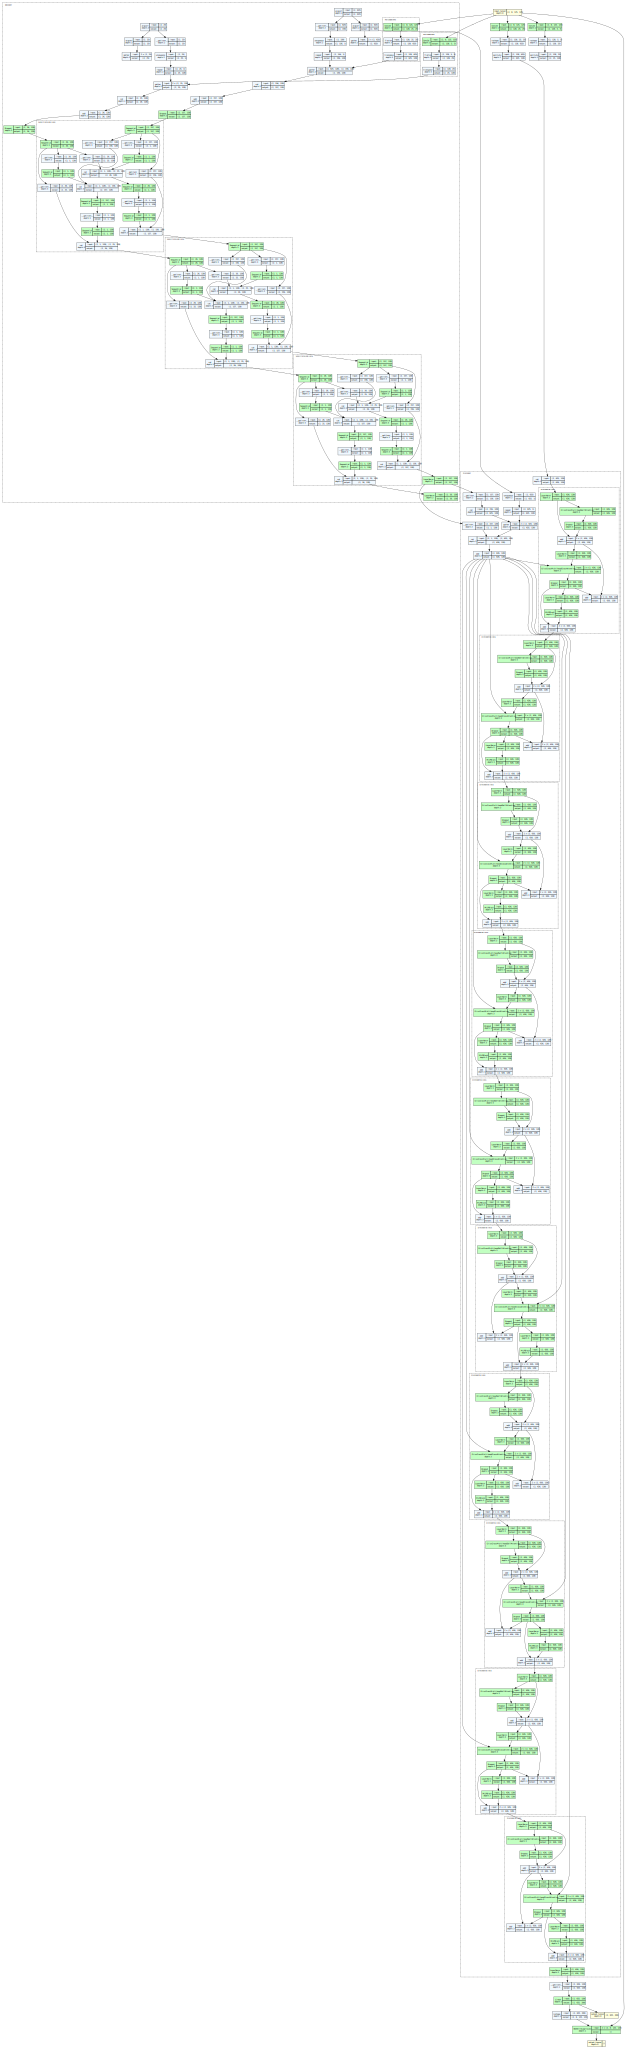

In [8]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot
model_graph = draw_graph(model, input_size=(2,8,125,125), expand_nested=True)
model_graph.visual_graph

In [9]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = torch.from_numpy(self.x[idx].astype('float32')).moveaxis(2, 0)
        sample = {'img' : img_1}
        
        return sample


In [10]:
dataset = Custom_Dataset(X_train)
sample = dataset.__getitem__(0)

print("X_train shape:", X_train.shape)
print("Sample image shape:", sample['img'].shape)
print("Sample image values:", sample['img'].max())

X_train shape: (80000, 125, 125, 8)
Sample image shape: torch.Size([8, 125, 125])
Sample image values: tensor(1.)


In [11]:
loss, pred = model(sample['img'].unsqueeze(0))
loss

tensor(0.7076, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

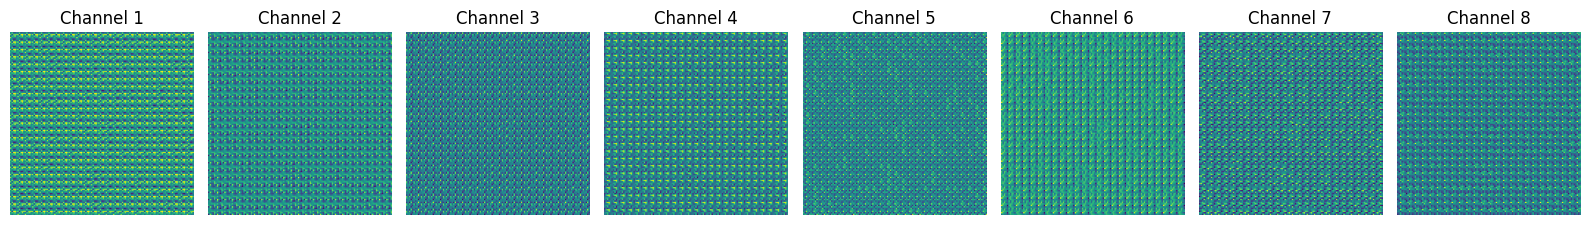

In [12]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

def visualize_prediction(pred):
    # Reshape prediction for visualization
    # preds = pred.reshape((pred.shape[0], 625, 200))

    def unpatchify(x):
        """
        x: (N, L, patch_size**2 * 3)
        imgs: (N, 8, H, W)
        """
        p = 5
        h = w = int(x.shape[1]**0.5)
        assert h * w == x.shape[1]
        
        x = x.reshape((x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape((x.shape[0], 8, h * p, w * p))
        return imgs

    # Unpatchify the prediction
    preds = unpatchify(pred)[0]

    # Convert to numpy array and move to CPU if necessary
    img = preds.permute(1, 2, 0).cpu().detach().numpy()

    # Number of channels
    num_channels = img.shape[2]

    # Create a single row of subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(16, 4))

    # Iterate through channels and plot each one in a subplot
    for i in range(num_channels):
        axes[i].imshow(img[:,:,i])  # Adjust colormap as needed
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()
visualize_prediction(pred)

In [13]:
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []

    model.train()
    scheduler.step()
    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        optimizer.zero_grad()

        loss, outputs = model(image)
        loss.sum().backward()
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        if step%100 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}')

        train_loss.append(loss_reduced.detach().cpu().numpy())
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            loss, outputs = model(image)
            
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            valid_loss.append(loss_reduced.detach().cpu().numpy())
            
            if step%500 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}')
            gc.collect
            
    return np.mean(train_loss), np.mean(valid_loss)

In [14]:
def data():

    ##Train Dataset
    train_dataset = Custom_Dataset(X_train)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=128,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=256,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [ ]:

def train_function(model, epochs):
    criterion = None
    lr = 0.00001
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./crossvit_model_epoch.pth')


def _mp_fn(rank, flags):
    try:
        # model = crossvit_tiny_224()
        model = xmp.MpModelWrapper(crossvit_tiny_224())
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=100)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=4, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1720821029.682398  253383 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1720821029.682491  253383 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1720821029.682498  253383 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1720821029.702386  253385 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1720821029.702386  253384 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1720821029.702474  253385 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1720821029.702474  253384 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1720821029.702482  253385 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API versio

num_training_steps = 31250, world_size=4


Epoch 1/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.7630472779273987


Epoch 1/100 (Train): 100batch [20:37,  6.64s/batch]

Train_Batch: 100, loss: 0.4447232782840729


Epoch 1/100 (Train): 156batch [26:45, 10.29s/batch]
Epoch 1/100 (Train): 156batch [26:43, 10.28s/batch]
Epoch 1/100 (Train): 156batch [26:42, 10.27s/batch]
Epoch 1/100 (Train): 156batch [26:42, 10.27s/batch]
Epoch 1/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.3440935015678406


Epoch 1/100 (Train): 19batch [04:06, 12.97s/batch]
Epoch 1/100 (Train): 19batch [04:06, 12.97s/batch]
Epoch 1/100 (Train): 19batch [04:06, 12.96s/batch]
Epoch 1/100 (Train): 19batch [04:06, 12.96s/batch]


Epoch 1/100, Train Loss: 0.5134, Val Loss: 0.3441


Epoch 2/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.3438141345977783


Epoch 2/100 (Train): 100batch [11:06,  6.50s/batch]

Train_Batch: 100, loss: 0.23223072290420532


Epoch 2/100 (Train): 156batch [17:09,  6.60s/batch]
Epoch 2/100 (Train): 156batch [17:09,  6.60s/batch]
Epoch 2/100 (Train): 156batch [17:09,  6.60s/batch]
Epoch 2/100 (Train): 156batch [17:10,  6.60s/batch]
Epoch 2/100 (Train): 1batch [00:03,  3.12s/batch]

Train_Batch: 0, loss: 0.19220098853111267

Epoch 2/100 (Train): 1batch [00:03,  3.06s/batch]

Epoch 2/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 2/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 2/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 2/100 (Train): 19batch [00:51,  2.70s/batch]


Epoch 2/100, Train Loss: 0.2574, Val Loss: 0.1922


Epoch 3/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.1917305737733841


Epoch 3/100 (Train): 100batch [10:54,  6.40s/batch]

Train_Batch: 100, loss: 0.14157503843307495


Epoch 3/100 (Train): 156batch [16:55,  6.51s/batch]
Epoch 3/100 (Train): 156batch [16:54,  6.50s/batch]
Epoch 3/100 (Train): 156batch [16:55,  6.51s/batch]
Epoch 3/100 (Train): 156batch [16:55,  6.51s/batch]
Epoch 3/100 (Train): 1batch [00:03,  3.35s/batch]

Train_Batch: 0, loss: 0.12221778929233551


Epoch 3/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 3/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 3/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 3/100 (Train): 19batch [00:51,  2.70s/batch]


Epoch 3/100, Train Loss: 0.1529, Val Loss: 0.1222


Epoch 4/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.12160243093967438


Epoch 4/100 (Train): 100batch [10:58,  6.57s/batch]

Train_Batch: 100, loss: 0.09546802937984467


Epoch 4/100 (Train): 156batch [17:00,  6.54s/batch]
Epoch 4/100 (Train): 156batch [16:57,  6.52s/batch]
Epoch 4/100 (Train): 156batch [16:57,  6.52s/batch]
Epoch 4/100 (Train): 156batch [16:57,  6.52s/batch]
Epoch 4/100 (Train): 1batch [00:03,  3.12s/batch]

Train_Batch: 0, loss: 0.08515919744968414


Epoch 4/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 4/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 4/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 4/100 (Train): 19batch [00:51,  2.69s/batch]


Epoch 4/100, Train Loss: 0.1014, Val Loss: 0.0851


Epoch 5/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.0844268724322319


Epoch 5/100 (Train): 16batch [01:47,  6.47s/batch]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 37/100 (Train): 100batch [11:09,  6.66s/batch]

Train_Batch: 100, loss: 0.015206915326416492


Epoch 37/100 (Train): 156batch [17:22,  6.68s/batch]
Epoch 37/100 (Train): 156batch [17:20,  6.67s/batch]
Epoch 37/100 (Train): 156batch [17:20,  6.67s/batch]
Epoch 37/100 (Train): 156batch [17:20,  6.67s/batch]
Epoch 37/100 (Train): 1batch [00:03,  3.30s/batch]

Train_Batch: 0, loss: 0.0166535135358572


Epoch 37/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 37/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 37/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 37/100 (Train): 19batch [00:51,  2.70s/batch]


Epoch 37/100, Train Loss: 0.0151, Val Loss: 0.0166


Epoch 38/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.014968125149607658


Epoch 38/100 (Train): 100batch [11:01,  6.48s/batch]

Train_Batch: 100, loss: 0.015139147639274597


Epoch 38/100 (Train): 156batch [17:06,  6.58s/batch]
Epoch 38/100 (Train): 156batch [17:08,  6.59s/batch]
Epoch 38/100 (Train): 156batch [17:06,  6.58s/batch]
Epoch 38/100 (Train): 156batch [17:07,  6.58s/batch]
Epoch 38/100 (Train): 1batch [00:03,  3.12s/batch]

Train_Batch: 0, loss: 0.016586389392614365


Epoch 38/100 (Train): 18batch [00:48,  2.66s/batch]

Epoch 38/100, Train Loss: 0.0150, Val Loss: 0.0166


Epoch 39/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.014897841960191727


Epoch 39/100 (Train): 100batch [11:03,  6.61s/batch]

Train_Batch: 100, loss: 0.015068274922668934


Epoch 39/100 (Train): 156batch [17:13,  6.62s/batch]
Epoch 39/100 (Train): 156batch [17:13,  6.63s/batch]
Epoch 39/100 (Train): 156batch [17:13,  6.62s/batch]
Epoch 39/100 (Train): 156batch [17:13,  6.62s/batch]
Epoch 39/100 (Train): 1batch [00:03,  3.12s/batch]

Train_Batch: 0, loss: 0.016577182337641716

Epoch 39/100 (Train): 1batch [00:03,  3.12s/batch]

Epoch 39/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 39/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 39/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 39/100 (Train): 19batch [00:51,  2.70s/batch]


Epoch 39/100, Train Loss: 0.0150, Val Loss: 0.0166


Epoch 40/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01487746275961399


Epoch 40/100 (Train): 100batch [11:00,  6.73s/batch]

Train_Batch: 100, loss: 0.015004835091531277


Epoch 40/100 (Train): 156batch [17:08,  6.59s/batch]
Epoch 40/100 (Train): 156batch [17:10,  6.60s/batch]
Epoch 40/100 (Train): 1batch [00:03,  3.37s/batch]h]

Train_Batch: 0, loss: 0.01647176407277584


Epoch 40/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 40/100 (Train): 19batch [00:51,  2.71s/batch]
Epoch 40/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 40/100 (Train): 19batch [00:51,  2.69s/batch]


Epoch 40/100, Train Loss: 0.0149, Val Loss: 0.0164


Epoch 41/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.014770226553082466

Epoch 42/100 (Train): 156batch [17:02,  6.55s/batch]
Epoch 42/100 (Train): 156batch [17:01,  6.55s/batch]
Epoch 42/100 (Train): 156batch [17:01,  6.55s/batch]
Epoch 42/100 (Train): 156batch [17:01,  6.55s/batch]
Epoch 42/100 (Train): 1batch [00:03,  3.11s/batch]

Train_Batch: 0, loss: 0.016366373747587204


Epoch 42/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 42/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 42/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 42/100 (Train): 19batch [00:51,  2.69s/batch]


Epoch 42/100, Train Loss: 0.0148, Val Loss: 0.0163


Epoch 43/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.014654310420155525


Epoch 43/100 (Train): 156batch [17:25,  6.70s/batch]
Epoch 43/100 (Train): 156batch [17:26,  6.71s/batch]
Epoch 43/100 (Train): 156batch [17:25,  6.70s/batch]
Epoch 43/100 (Train): 156batch [17:25,  6.70s/batch]
Epoch 43/100 (Train): 1batch [00:03,  3.16s/batch]

Train_Batch: 0, loss: 0.016317788511514664

Epoch 43/100 (Train): 1batch [00:03,  3.16s/batch]

Epoch 43/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 43/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 43/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 43/100 (Train): 19batch [00:51,  2.69s/batch]


Epoch 43/100, Train Loss: 0.0147, Val Loss: 0.0163


Epoch 44/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01460297591984272


Epoch 44/100 (Train): 156batch [17:06,  6.58s/batch]
Epoch 44/100 (Train): 156batch [17:04,  6.57s/batch]
Epoch 44/100 (Train): 156batch [17:04,  6.57s/batch]
Epoch 44/100 (Train): 156batch [17:04,  6.57s/batch]
Epoch 44/100 (Train): 1batch [00:03,  3.20s/batch]

Train_Batch: 0, loss: 0.016276124864816666


Epoch 44/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 44/100 (Train): 19batch [00:51,  2.69s/batch]
Epoch 44/100 (Train): 19batch [00:51,  2.70s/batch]
Epoch 44/100 (Train): 19batch [00:51,  2.69s/batch]


Epoch 44/100, Train Loss: 0.0147, Val Loss: 0.0162


Epoch 45/100 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.014554955065250397


Epoch 45/100 (Train): 50batch [05:26,  6.42s/batch]